# TWO WAY DESIGN (2WD)

This lecture continues the analysis of the Wolf model of glycolytic oscillations to consider the effects of two parameters in combination.

A two way design (2WD) is used to identify interactions between factors.
This means that there is an experiment for every combination of levels of both factors.
That is, there are $n_1 \times n_2$ experiments if there are $n_i$ levels of the two factors.

## Challenges

1. **Combinatorics.**
The Wolf model has 16 parameters, which means that there are 120 interactions, each of which need to be calculated at several levels.
With 10 levels for each interaction, this results in $10 \times 10 \times 120 = 12,000$ constants to calculate.
1. **Visualization.**
How should we present the responses that clearly presents which interaction terms are displayed, their values, and patterns in the responses?
1. **Generalizing 1WD codes for 2WD**. ``runExperiments`` and other codes assumed a 1-way interaction.

# Preliminaries

## Imports

In [1]:
!pip install -q tellurium
#
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import fftpack
import tellurium as te
import seaborn as sns

## Constants for models and simulation

In [2]:
# Constants
AMPLIDX = 1  # Index of amplitude values
FONTSIZE = 16
FREQIDX = 0  # Index of frequency values
TIME = "time"
SMALLEST_PCT = -100  # Smallest percent change in a parameter value
WOLF_RR = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000691.3?filename=BIOMD0000000691_url.xml")
WOLF_MODEL = WOLF_RR.getAntimony()
print(WOLF_MODEL)
# Constants used in the analysis of the Wolf model
START = 0
END = 20
NUMPT = 1000  # number of points to simulate
rr = te.loada(WOLF_MODEL)

// Created by libAntimony v2.13.2
function Constant_flux__irreversible(v)
  v;
end

Constant_flux__irreversible is "Constant flux (irreversible)"

function function_for_v2(k2, S2, N1)
  k2*S2*N1;
end

function_for_v2 is "function for v2"

function function_for_d_dt_S4_ex(phi, J1, J2)
  (phi/2)*(J1 + J2);
end

function_for_d_dt_S4_ex is "function for d/dt(S4_ex)"

function function_for_v1(k1, S1, A3, K_I, q)
  k1*S1*A3*(1 + (A3/K_I)^q)^-1;
end

function_for_v1 is "function for v1"

function function_for_v3(k3, S3, A2)
  k3*S3*A2;
end

function_for_v3 is "function for v3"


model *Wolf2000___Cellular_interaction_on_glycolytic_oscillations_in_yeast()

  // Compartments and Species:
  compartment Cell_1, Cell_2, Compartment;
  species S1__Cell_1_ in Cell_1, S1__Cell_2_ in Cell_2, S2__Cell_1_ in Cell_1;
  species S2__Cell_2_ in Cell_2, S3__Cell_1_ in Cell_1, S3__Cell_2_ in Cell_2;
  species S4__Cell_1_ in Cell_1, S4__Cell_2_ in Cell_2, N2__Cell_1_ in Cell_1;
  species N2__Cell_2_ in Cell_2,

## General helper unctions

In [3]:
def arrToDF(arr):
    """
    Converts a NamedArray to a DataFrame.
    
    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    return pd.DataFrame(arr, columns=columns)

# TESTS
rr = te.loada("A -> B; 1; A=0; B=0; a=2")
arr = rr.simulate()
df = arrToDF(arr)
assert(isinstance(df, pd.DataFrame))
trues = ["[" not in c and "]" not in c for c in df.columns]
assert(all(trues))

In [4]:
def getParameterValueDct(model):
    """
    Finds the name and value of all parameters.
    
    Parameters
    ----------
    model: str (Antimony model)
    
    Returns
    -------
    dict (key: str, value: float)
    """
    rr = te.loada(model)
    dct = {}
    for parameter_name in rr.model.getGlobalParameterIds():
        try:
            rr[parameter_name] = rr[parameter_name]
            dct[parameter_name] = rr[parameter_name]
        except:
            pass
    return dct
                
# Tests
dct = getParameterValueDct(WOLF_MODEL)
assert(isinstance(dct, dict))
assert("k1" in dct.keys())
print("OK!")

OK!


In [5]:
WOLF_DF = arrToDF(rr.simulate(START, END, NUMPT))
WOLF_DF = WOLF_DF.set_index("time")
WOLF_SPECIES = list(WOLF_DF.columns)
SPECIES = WOLF_SPECIES[1]  # Used in tests
PARAMETER = "K_I"  # Used in tests

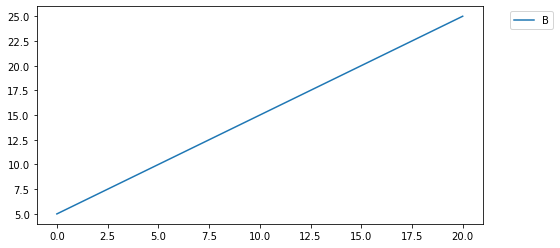

In [6]:
def timePlots(df=WOLF_DF, title="", isPlot=True):
    """
    Plots floating species over time.
    
    Parameters
    ----------
    df: DataFrame
        index: time
        columns: species
    title: str
        Title of plot
    isPlot: bool
    """
    fig, ax = plt.subplots(1, figsize=(8, 4))
    arr = df.values
    colnames = df.columns
    p = ax.plot(df.index, arr[:,1:])
    _ = ax.legend(p, colnames[1:], bbox_to_anchor=(1.05, 1), loc='upper left')
    _ = ax.set_title(title)
    if isPlot:
        plt.show()
    
# Tests
timePlots(isPlot=False)

## DOE Constants

In [40]:
PARAMETER_DCT = getParameterValueDct(WOLF_MODEL)
WOLF_FACTORS = list(PARAMETER_DCT.keys())
WOLF_DF = arrToDF(WOLF_RR.simulate())
WOLF_SPECIES = list(WOLF_DF.columns)
WOLF_SPECIES.remove("time")

## DOE Helper functions

In [8]:
def runSimulation(parameter_dct, roadrunner=None, model=WOLF_MODEL,
      startTime=START, endTime=END, numPoint=NUMPT):
    """
    Runs a simulation for parameters with percentage changes from baseline values.

    Parameters
    ----------
    parameter_dct: dict
       key: parameter
       value: float
           percent change
    roadrunner: ExtendedRoadRunner
    startTime: float
    endTime: float
    numPoint: int
       
    Returns
    -------
    DataFrame: simulation results
        index: time
        columns: floating species
    """
    if roadrunner is None:
        roadrunner = te.loada(model)
    else:
        roadrunner.resetAll()
    for parameter, percent in parameter_dct.items():
        baseValue = roadrunner[parameter]
        roadrunner[parameter] = baseValue*(1 + 0.01*percent)
    # Run the simulation
    data = roadrunner.simulate(startTime, endTime, numPoint)
    df = arrToDF(data)
    return df.set_index("time")

# Tests
parameter_dct = {PARAMETER: 10}
df = runSimulation(parameter_dct)
assert(isinstance(df, pd.DataFrame))
assert(len(df) > 0)
print("OK!")

OK!


In [9]:
def runSimulations(parameter, percents, model=WOLF_MODEL, isPlot=True):
    """
    Runs experiments and produces plots for the percent changes in parameter values.

    Parameters
    ----------
    parameter: str
    percents: list-float
        list of percent change in values
          (smallest value is -100)
    model: str (Antimony model)
          
    Returns
    -------
    dict:
        key: pct
        value: DataFrame
    """
    dct = {}
    for percent in percents:
        dct[percent] = runSimulation({parameter: percent})
    return dct

# Tests
percents = [-10, 0, 10]
resultDct = runSimulations(PARAMETER, percents, isPlot=False)
assert(len(set(percents).symmetric_difference(resultDct.keys())) == 0)
print("OK!")

OK!


In [10]:
#TODO: use runSimulation
def runSimulations_old(parameter, percents, model=WOLF_MODEL, isPlot=True):
    """
    Runs experiments and produces plots for the percent changes in parameter values.

    Parameters
    ----------
    parameter: str
    percents: list-float
        list of percent change in values
          (smallest value is -100)
    model: str (Antimony model)
          
    Returns
    -------
    dict:
        key: pct
        value: DataFrame
    """
    roadrunner = te.loada(model)
    baseValue = roadrunner[parameter]
    if not parameter in roadrunner.keys():
        raise ValueError("Unknown parameter name: %s" % parameter)
    resultDct = {}
    for percent in percents:
        roadrunner.resetAll()
        percent = max(percent, SMALLEST_PCT)
        frac = 0.01*percent
        newValue = baseValue*(1 + frac)
        roadrunner[parameter] = newValue
        df = arrToDF(roadrunner.simulate(START, END, NUMPT))
        title = "%s: %f (%d%%)" % (parameter, newValue, percent)
        resultDct[percent] = df
        if isPlot:
            timePlots(df=df, title=title)
    return resultDct

# Tests
percents = [-10, 0, 10]
resultDct = runSimulations(PARAMETER, percents, isPlot=False)
assert(len(set(percents).symmetric_difference(resultDct.keys())) == 0)
print("OK!")

OK!


In [11]:
def calculateFft(molecule, df, offset=100):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.
    
    Parameters
    ----------
    molecule: str
    df: DataFrame
        index: time
        columns: species
    offset: int
        Initial data that are not included in the FFT calculation
             
    Returns
    -------
    list-float, list-float
        freqs, fftValues
    """
    times = np.array(df.index)
    values = df[molecule].values
    numPoint = len(times)
    count = numPoint - offset
    endTime = times[-1]
    freqs = fftpack.fftfreq(count, endTime/numPoint)
    fftValues = np.abs(fftpack.fft(values[offset:]))
    # Eliminate frequency of 0
    freqs = freqs[1:]
    fftValues = fftValues[1:]
    return freqs, fftValues

# Tests
freqs, fftValues = calculateFft(SPECIES, WOLF_DF)
assert(max(fftValues) > 90)  # Top frequency should have a large magnitude
print("OK!")

OK!


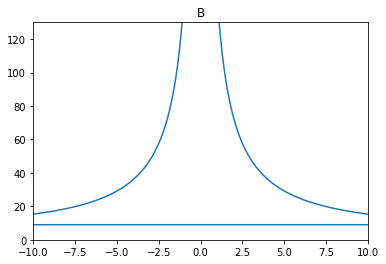

In [12]:
def plotFft(molecule, df=WOLF_DF, ax=None, isPlot=True, **kwargs):
    """
    Plot the FFT for a molecule.
    
    Parameters
    ----------
    df: DataFrame
        index: time
        columns: floating species
    ax: Matplotlib.Axes
    kwargs: dict
        optional arguments passed to FFT calculation
    """
    if ax is None:
        _, ax = plt.subplots(1,1)
    freqs, fftValues = calculateFft(molecule, df=df, **kwargs)
    ax.plot(freqs, fftValues)
    ax.set_title(molecule)
    ax.set_ylim([0, 130])
    ax.set_xlim([-10, 10])
    if isPlot:
        plt.show()
    
# Tests
plotFft(SPECIES, isPlot=False)  # "Smoke" test

In [13]:
def calculatePeakFrequency(molecule, data_df, numDelete=0, offset=100):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.
    
    Parameters
    ----------
    molecule: str
    data_df: DataFrame
    offset: int
        Initial data that are not included in the FFT calculation
             
    Returns
    -------
    float: peak frequency
    """
    def getIndexOfMax(arr):
        maxx = max(arr)
        lst = list(arr)
        return lst.index(maxx)
    def deleteArrayElement(arr, idx):
        lst = list(arr)
        lst1 = lst[:idx]
        lst2 = lst[idx+1:]
        newLst = lst1.extend(lst2)
        return np.array(lst1)    
    #
    frequencies, amplitudes = calculateFft(molecule, data_df)
    # Delete the largest N values
    for _ in range(numDelete):
        maxIdx = getIndexOfMax(amplitudes)
        frequencies = deleteArrayElement(frequencies, maxIdx)
        amplitudes = deleteArrayElement(amplitudes, maxIdx)
    # Report the next highest value
    maxIdx = getIndexOfMax(amplitudes)
    return frequencies[maxIdx]

# TESTS
peak_frequency = calculatePeakFrequency(SPECIES, WOLF_DF)
assert(peak_frequency > 0)
print("OK!")

OK!


In [14]:
def runFFTExperiment(parameter_dct, **kwargs):
    """ 
    Runs an experiment by changing parameters by the specified
    fractions and calculating FFT peak frequencies and amplitudes.
    
    Parameters
    ----------
    parameter_dct: dict
       key: parameter name
       value: percent change the parameter
    kwargs: dict
       keyword arguments passed to runSimulation
       
    Returns
    -------
    frequencySer: pd.Series
        index: molecule
        value: frequency with largest amplitude
    """
    df = runSimulation(parameter_dct, **kwargs)
    frequencyDct = {}
    for molecule in df.columns:
        frequency = calculatePeakFrequency(molecule, df) 
        frequencyDct[molecule] = frequency
    return pd.Series(frequencyDct)

# Tests
parameter_dct = {WOLF_FACTORS[0]: 5}
freq_ser = runFFTExperiment(parameter_dct)
assert(isinstance(freq_ser, pd.Series))
assert(len(freq_ser) > 0)
print("OK!")

OK!


# Generalize runExperiments
Generalize ``runExperiments`` so that it calculates responses for all combinations of levels of two factors.

In [15]:
def runExperiments2WD(factor1, factor2, percent1s, percent2s, isRelative=True):
    """
    Runs experiments for multiple factors at different percent changes in factor levels.
    
    Parameter
    ---------
    factor1: str
    factor2: str
    percent1s: list-int
    percent2s: list-int
    isRelative: bool
        True: values are percent changes relative to baseline
        False: absolute value
        
    Returns
    -------
    frequencyDF: DataFrame; amplitude: DataFrame
       index: tuple of percent changes in factor values
       columns: molecule
       value: depends on isRelative
       index.name: string of tuple (rowFactor, columnFactor)
    """
    # Constants
    INDEX1 = "index1"
    INDEX2 = "index2"
    def appendSer(ser, baseSer, sers):
        adjSer = 100*(ser - baseSer) / baseSer
        sers.append(pd.DataFrame(adjSer).transpose())
    def calcResult(sers):
        resultDF = pd.concat(sers)
        resultDF[INDEX1] = index1
        resultDF[INDEX2] = index2
        resultDF = resultDF.set_index([index1, index2])
        for column in [INDEX1, INDEX2]:
            del resultDF[column]
        resultDF.index.name = str((factor1, factor2))
        return resultDF
    # Initializations
    index1 = []
    index2 = []
    frequencySers = []  # Collection of experiment results
    baseFrequencySer = runFFTExperiment({})
    # Calculate the changes
    for percent1 in percent1s:
        for percent2 in percent2s:
            #indices.append("%d_%d" % (percent1, percent2))
            index1.append(percent1)
            index2.append(percent2)
            factorDct = {factor1: percent1, factor2: percent2}
            frequencySer = runFFTExperiment(factorDct)
            appendSer(frequencySer, baseFrequencySer, frequencySers)
    # Construct the result dataframe
    frequencyDF = calcResult(frequencySers)
    return frequencyDF

# Tests
percents = [-7, -5, -2, 0, 2, 5, 7]
freq_df = runExperiments2WD(WOLF_FACTORS[0], WOLF_FACTORS[1], percents, percents)
columns = list(freq_df.columns)
assert(freq_df.loc[(percents[0], percents[0]), columns[2]] < 0 )
print("OK!")

OK!


**Data: Response2WDDF**. We will describe the response for a 2WD using a dataframe structured as above.
* Columns: names of factors
* index.name: str(str, str) - factors changed
* Index: (int, int) (in same order as index)
* Values: float (percent change)

In [16]:
# Test Data
TEST_FDF = freq_df

# Visualizing results of an Experiment

We will visualize the 2FD reponses using a heatmap. The horizontal and vertical axes
will be percent changes in parameter values; cells will be colored with the change in magnitude.

In [17]:
WOLF_FACTORS

['kappa', 'k1', 'K_I', 'q', 'k2', 'k3', 'k4', 'k5', 'k6', 'k', 'J0', 'phi']

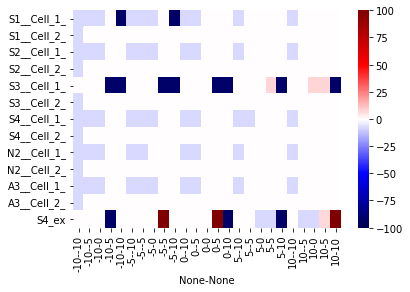

In [18]:
# Presentation of all variables that scales to a large number of interactions
percents = [-10, -5, 0, 5, 10]
freq_df = runExperiments2WD("kappa", "k1", percents, percents)
_ = sns.heatmap(freq_df.transpose(), cmap='seismic', vmin=-100, vmax=100)

Insights
1. All chemical species have similar trends in osciallation patterns.
1. J1_Ki has more influence on oscillation frequency than J1_k1.
1. Non-monotone effect when J1_Ki is increased in that oscillation frequency increase and then radically fall.

In [19]:
# Baseline
runSimulation({})

,S1__Cell_1_,S1__Cell_2_,S2__Cell_1_,S2__Cell_2_,S3__Cell_1_,S3__Cell_2_,S4__Cell_1_,S4__Cell_2_,N2__Cell_1_,N2__Cell_2_,A3__Cell_1_,A3__Cell_2_,S4_ex
time,,,,,,,,,,,,,
0.00000,5.800000,2.900000,0.900000,0.450000,0.200000,0.100000,0.200000,0.100000,0.100000,0.050000,3.200000,0.200000,0.100000
0.02002,5.833804,2.764976,0.836439,0.752186,0.235319,0.071996,0.188386,0.171733,0.124546,0.092731,3.179877,0.016784,0.098798
0.04004,5.867165,2.736294,0.780148,0.824618,0.254758,0.068322,0.182383,0.197387,0.135174,0.117447,3.174900,0.015871,0.098117
0.06006,5.900352,2.708752,0.730760,0.884306,0.264286,0.070123,0.179735,0.207327,0.138745,0.130912,3.177168,0.016387,0.097627
0.08008,5.933484,2.678002,0.687661,0.941425,0.267587,0.073440,0.178671,0.212571,0.138598,0.139121,3.181847,0.017335,0.097231
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19.91992,1.315596,0.957078,0.242678,2.709412,0.188733,0.206379,0.170462,0.410040,0.077580,0.182923,3.326071,0.126203,0.107201
19.93994,1.370278,0.774155,0.223362,2.804081,0.174881,0.216303,0.168534,0.435552,0.073565,0.180159,3.309677,0.158969,0.108857
19.95996,1.424648,0.590865,0.207069,2.887515,0.161175,0.226392,0.167054,0.458137,0.069771,0.178117,3.289096,0.208948,0.110705


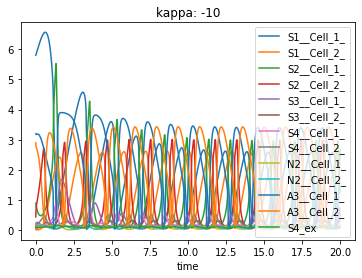

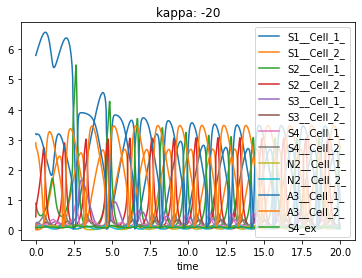

In [31]:
# Decrease k1
ax = runSimulation({"kappa": -10}).plot()
_ = ax.set_title("kappa: -10")
ax = runSimulation({"kappa": -20}).plot()
_ = ax.set_title("kappa: -20")

## Visualizing interactions for a single molecule

The following code makes use of the pandas ``pivot`` function to create a table where rows and columns represent different levels of the two factors.

In [43]:
def pivotResponse(responseDF, molecule):
    """
    Creates a DataFrame in which values of the parameters are rows and columns.
    
    Parameters
    ----------
    responseDF: DataFrame
        columns: molecule names
        rows: tuple of percent changes in parameters
        values: response
        index.name: string of tuple (rowParameter, columnParameter)
    molecule: str
        
    Returns
    -------
    DataFrame
        columns: values of columnParameter
        rows: values of rowParameter
        cells: response for molecule
    """
    LEVEL0 = "level_0"
    LEVEL1 = "level_1"
    df = responseDF.reset_index()
    resultDF = pd.pivot_table(df, values=molecule, index=LEVEL0, columns=LEVEL1)
    parameters = eval(responseDF.index.name)
    resultDF.index.name = parameters[0]
    resultDF.columns.name = parameters[1]
    return resultDF

# Tests
df = pivotResponse(TEST_FDF, WOLF_SPECIES[0])
#pd.pivot_table(df, values="Glucose", index="level_0", columns="level_1")
assert(len(df.index) == len(df.columns))
print("OK!")

OK!


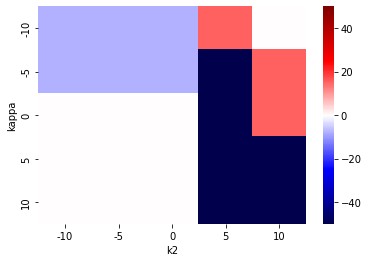

In [46]:
# Visualization that provides more insight
percents = [-10, -5, 0, 5, 10]
fDF = runExperiments2WD("kappa", "k2", percents, percents)
_ = sns.heatmap(pivotResponse(fDF, WOLF_SPECIES[0]), cmap='seismic', vmin=-50, vmax=50)

A function that encapsulates the foregoing for the output of 2WD experiments.

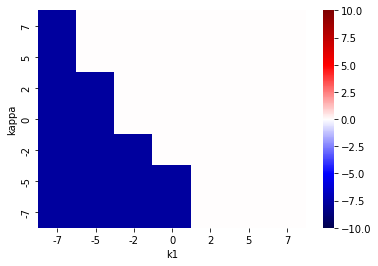

In [54]:
def makeHeatmap(responseDF, molecule, isColorbar=True, ax=None, vmin=-100, vmax=100, cbar_ax=None):
    """
    Creates a heatmap showing the interactions of response values for two parameters.
    
    Parameters
    ----------
    reponseDF: DataFrame
        index: tuples of percent changes in parameter values
        columns: molecule
        values: response
    molecule: str
    isColorbar: bool
        show the colorbar
    vmin: float
        minimum value in color bar
    vmax: float
        maximum value in color bar
    cbar_ax: Axes
    """
    df = pivotResponse(responseDF, molecule)
    df = df.sort_index(ascending=False)  # Show large values on top
    if ax is None:
        ax = sns.heatmap(df, cmap='seismic', vmin=vmin, vmax=vmax, cbar=isColorbar, cbar_ax=cbar_ax)
    else:
        _ = sns.heatmap(df, cmap='seismic', vmin=vmin, vmax=vmax, cbar=isColorbar, ax=ax, cbar_ax=cbar_ax)
    return ax

# Tests
_ = makeHeatmap(TEST_FDF, WOLF_SPECIES[0], vmin=-10, vmax=10)

# Calculating DOE Parameters

For 2WD, we must calculate $\mu, \alpha_{i, k_i}, \alpha_{i, k_i, j, k_j}$.
1. Use 1WD to obtain $\mu, \alpha_{i, k_i}$
1. Calculate $y_{i, k_i, j, k_j}$ responses
1. Calculate $\alpha_{i, k_i, j, k_j}$: $\alpha_{i, k_i, j, k_j} = y_{i, k_i, j, k_j} - \mu
- \alpha_{i, k_i} - \alpha_{j, k_j}$

## Extracting 1WD information from a 2WD experiment

A 2WD experiment contains information from two 1WD experiments.
The function ``calc1WDParameters`` calculates $\mu$, $\alpha_{i, k_i}$, $\alpha_{j, k_j}$.

In [56]:
def calc1WDParameters(response2WDDF):
    """
    Constructs a 1WD response for a single molecule from the results for a 2WD experiment.
    
    Parameters
    ----------
    response2WDDF: DataFrame (Response2WDDF)
    factor: str
    molecule: str
    
    Returns
    -------
    Series: mu
    DataFrame: response for first factor
        index: int (percent change)
        value: float (percent change)
    DataFrame: response for second factor
        index: int (percent change)
        value: float (percent change)  
    """
    def calcFactorSer(pos):
        """
        Calculates the Series for a factor.
        
        Parameters
        ----------
        pos: int
            in the set {0, 1}
          
        Returns
        -------
        DataFrame
        """
        # Find the levels
        levels = list(set([i[pos] for i in response2WDDF.index]))
        levels.sort()
        # Find the indices that determine the 1WD responses
        indices = [(i, 0) for i in levels]
        if pos == 1:
            indices = [(j, i) for i,j in indices]
        #
        df = response2WDDF.loc[indices]
        newIndices = [i[pos] for i in df.index]
        df.index = newIndices
        return df
    # 
    mu = response2WDDF.loc[(0, 0), :]
    alphaiDF = calcFactorSer(0) - mu
    alphajDF = calcFactorSer(1) - mu
    #
    return mu, alphaiDF, alphajDF

# TESTS
muSer, df1, df2 = calc1WDParameters(fDF)
assert(all([m == 0 for m in muSer]))
for df in [df1, df2]:
    assert(isinstance(df, pd.DataFrame))
    assert(len(df) == 5)
print("OK!")

OK!


## Calculating $\alpha_{i, k_i, j, k_j}$

In [57]:
def calc2WDParameters(response2WDDF):
    """
    Calculates the design of experiment parameters for a 2-Way Design.
    Assumes that there is a level of 0.

    Parameters
    ----------
    DataFrame
       index: tuple of percent changes in factor values
       columns: molecule
       value: float (response)
       index.name: string of tuple (rowFactor, columnFactor)
    
    Returns
    -------
    Series: mu values for factors
    pd.DataFrame: alpha_i,k_i
        column: molecule
        index: factor i levels
        value: float
    pd.DataFrame: alpha_j,k_j
        column: molecule
        index: factor j levels
        value: float
    pd.DataFrame: alpha_i,k_i,j,k_j
        column: molecule
        index: factor i, factor j levels
        value: float
    """
    mu, alphaiDF, alphajDF = calc1WDParameters(response2WDDF)
    alphaijDF = response2WDDF - mu
    # Adjust for alpha_i_ki and alpha_j_kj
    for idx, row in alphaijDF.iterrows():
        iLevel, jLevel = idx
        alphaijDF.loc[idx, :] = alphaijDF.loc[idx, :].values - alphaiDF.loc[iLevel, :].values  \
            - alphajDF.loc[jLevel, :].values
    #
    return mu, alphaiDF, alphajDF, alphaijDF

# TESTS
muSer, alphaiDF, alphajDF, alphaijDF = calc2WDParameters(fDF)
assert(isinstance(muSer, pd.Series))
assert(isinstance(alphaiDF, pd.DataFrame))
assert(isinstance(alphajDF, pd.DataFrame))
assert(isinstance(alphaijDF, pd.DataFrame))
assert(len(alphaijDF) == len(alphaiDF)*len(alphajDF))
print("OK!")

OK!


# Running a Study

A study for 2WD must considerations *combinations* of changes in levels for two factors.
So, running a study must specify: (a) the list of factors considered for changes in combinations
and (b) the levels of factors.

## Calculating responses for 2WD

In [64]:
def runStudy2WD(factor1, factor2, percents, isRelative=True):
    """
    Calculates parameters for a 2WD study.
    
    Parameters
    ----------
    molecule: str
    factor1: str
    factor2: str
    percents: list-int
    isRelative: bool
       Results are percent change w.r.t. base
       
    Returns
    -------
    Series: mean values
    pd.DataFrame: alpha_i,k_i (response2WDDF)
    pd.DataFrame: alpha_j,k_j (response2WDDF)
    pd.DataFrame: alpha_i,k_i,j,k_j (response2WDDF)
    """
    # Get the 2WD parameters
    frequency_df = runExperiments2WD(factor1, factor2, percents, percents,
                                                 isRelative=isRelative)
    #
    return calc2WDParameters(frequency_df)

# TESTS
mu_ser, alphai_df, alphaj_df, betaij_df = runStudy2WD(WOLF_FACTORS[1], "kappa", [-10, -7, -5, 0, 5, 7, 10])
assert(isinstance(mu_ser, pd.Series))
for df in [alphai_df, alphaj_df, betaij_df]:
    assert(len(df) > 0)
    assert(isinstance(df, pd.DataFrame))
print("OK!")

OK!


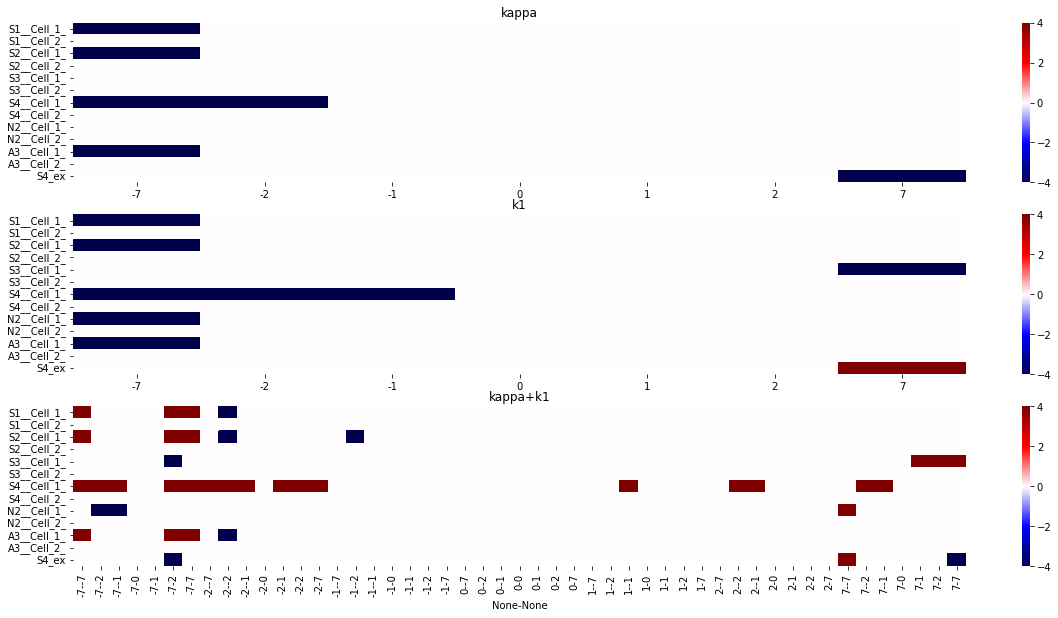

In [69]:
def plot2WD(factor1, factor2, percents, isRelative=True, figsize=(20, 10)):
    """
    Plots the alpha for 1WD and 2WD.
    
    Parameters
    ----------
    molecule: str
    factor1: str
    factor2: str
    percents: list-int
    isRelative: bool
       Results are percent change w.r.t. base
    figisze: tuple-int
       Size of figures
    """
    def plotParameters(df, ax, factor):
        sns.heatmap(df.T, cmap='seismic', vmin=vmin, vmax=vmax, ax=ax)
        ax.set_title(factor)
    #
    vmin = -4
    vmax = 4
    # Get the 2WD parameters
    mu, alphaiDF, alphajDF, alphaijDF = runStudy2WD(factor1, factor2, percents, isRelative=isRelative)
    fig, axes = plt.subplots(3, figsize=figsize)
    plotParameters(alphaiDF, axes[0], factor1, is_plot=is_plot)
    plotParameters(alphajDF, axes[1], factor2)
    plotParameters(alphaijDF, axes[2], factor1 + "+" + factor2)
    
    
# TESTS
plot2WD("kappa", "k1", [-7, -2, -1, 0, 1, 2, 7], is_plot=False)

## Question
1. Analyze realtive frequencies for Glucose.

## Solution

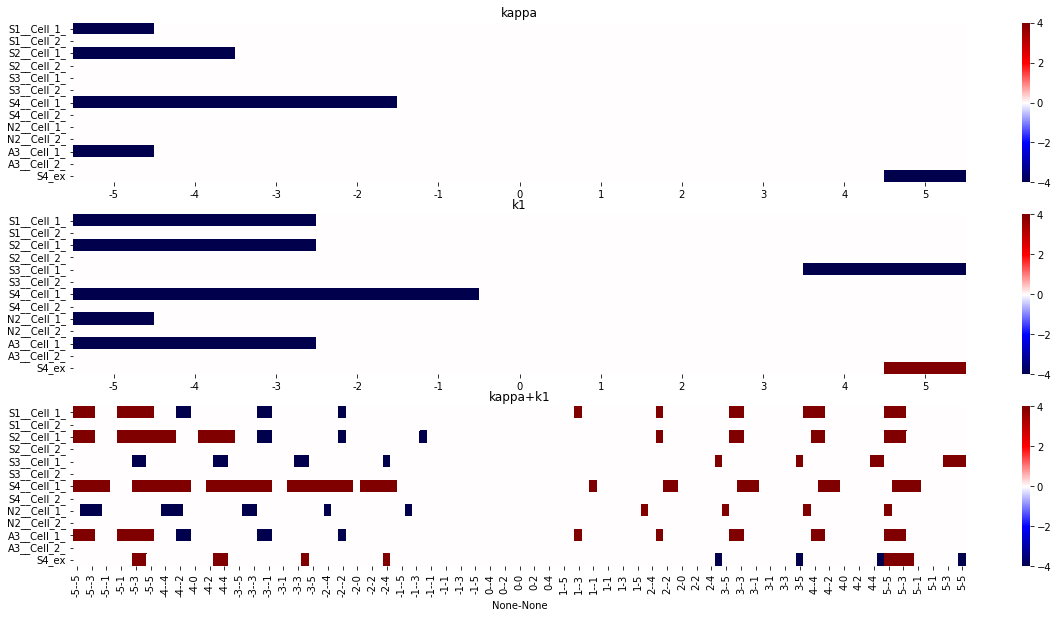

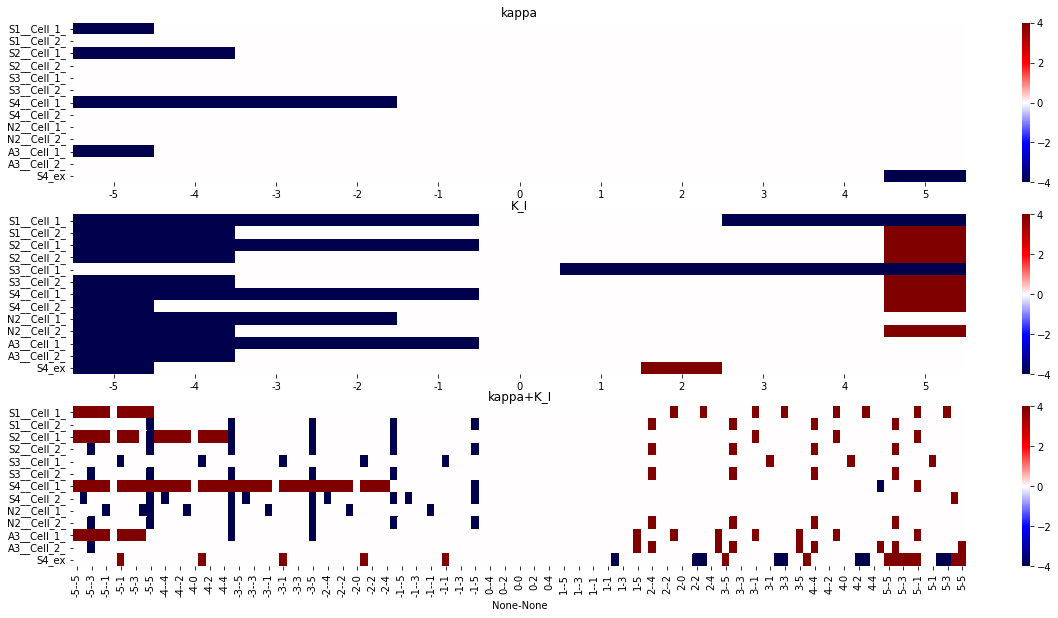

In [70]:
# Analysis for frequency with relative (precentage) responses
percents = 3*(np.array(range(7)) - 3)
percents = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
for prm in WOLF_FACTORS[1:3]:
    plot2WD(WOLF_FACTORS[0], prm, percents, isRelative=True)  

## Question
1. Which combination of parameters for which response suggest a strong interaction between parameter pairs?# Analysis for frequency with relative (precentage) responses